In [1]:
#import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

np.random.seed(1)

In [6]:

#load dataset
keys = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label.']
train = pd.read_csv("C:\\Users\\asusc\\Downloads\\cs549 final\\kddcup.data.gz", names=keys, compression='gzip')
test = pd.read_csv("C:\\Users\\asusc\\Downloads\\cs549 final\\corrected.gz", names=keys, compression='gzip')

#one-hot preprocessing (method 1)
def preprocess_df(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    one_hot_columns = ['protocol_type', 'service', 'flag']
    X = pd.get_dummies(X, columns=one_hot_columns)
    y = np.array([0 if label == 'normal.' else 1 for label in y])
    return X, y

#preprocess the data
X_train, y_train = preprocess_df(train)
X_test, y_test = preprocess_df(test)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0) #formats train columns to follow test, fills in 0 when empty

#normalization preprocessing (method 2)
X_train = (X_train - X_train.mean()) / (X_train.std() + 1e-6)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-6)

#converts to numpy array and formats for processing
X_train = X_train.to_numpy().T
X_test = X_test.to_numpy().T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (122, 4898431) (1, 4898431)
Test shape: (122, 311029) (1, 311029)


In [7]:
#sigmoid activation function for forward prop
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

#derivative of sigmoid for back prop
def sigmoid_derivative(A):
    return A * (1 - A)

#initialize weights and biasies 
def init_params(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

In [8]:
#simple 2 layer forward prop with tanh and sigmoid
def forward_prop(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return A2, cache


In [9]:
#simple back prop, calculates gradient descent, updates weights with derivative of tanh and sigmoid
def backward_prop(X, Y, params, cache):
    m = X.shape[1]
    W2 = params['W2']
    A1, A2 = cache['A1'], cache['A2']
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.dot(W2.T, dZ2) * (1 - A1**2)
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads


In [10]:
#structures NN, runs forward prop and backprop, updates weights, and outputs loss
def train(X, Y, n_h, iterations=1000, lr=0.1):
    n_x = X.shape[0]
    n_y = 1
    params = init_params(n_x, n_h, n_y)
    for i in range(iterations):
        A2, cache = forward_prop(X, params)
        grads = backward_prop(X, Y, params, cache)
        params['W1'] -= lr * grads['dW1']
        params['b1'] -= lr * grads['db1']
        params['W2'] -= lr * grads['dW2']
        params['b2'] -= lr * grads['db2']
        if i % 100 == 0:
            loss = -np.mean(Y * np.log(A2 + 1e-8) + (1 - Y) * np.log(1 - A2 + 1e-8))
            print(f"Iteration {i}, Loss: {loss:.4f}")
    return params


In [11]:
#evaulates model on accuracy, precision, and recall
def evaluate(X, Y, params, threshold=0.5):
    A2, _ = forward_prop(X, params)
    Y_hat = (A2 > threshold).astype(int)
    acc = accuracy_score(Y.flatten(), Y_hat.flatten())
    prec = precision_score(Y.flatten(), Y_hat.flatten())
    rec = recall_score(Y.flatten(), Y_hat.flatten())
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    print("Confusion Matrix:", confusion_matrix(Y.flatten(), Y_hat.flatten()))
    return A2

params = train(X_train, y_train, n_h=25, iterations=200, lr=0.5)
evaluate(X_test, y_test, params)


Iteration 0, Loss: 0.6937
Iteration 100, Loss: 0.0104
Accuracy: 0.9193, Precision: 0.9949, Recall: 0.9044
Confusion Matrix: [[ 59441   1152]
 [ 23952 226484]]


array([[0.0410398 , 0.0410398 , 0.0410398 , ..., 0.04142645, 0.04204081,
        0.04142645]])

Accuracy: 0.9193, Precision: 0.9949, Recall: 0.9044
Confusion Matrix: [[ 59441   1152]
 [ 23952 226484]]


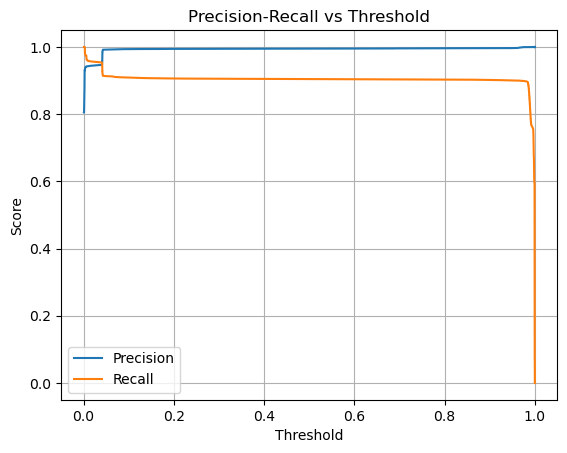

In [12]:
#plots precision and recall
probs = evaluate(X_test, y_test, params, threshold=0.5)
precision, recall, thresholds = precision_recall_curve(y_test.flatten(), probs.flatten())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()
